# Connet to Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import datasets,transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix

# 各種雜訊定義

In [ ]:
# Custom transform to add Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# Custom transform to add Speckle noise
class AddSpeckleNoise(object):
    def __init__(self, noise_level=0.1):
        self.noise_level = noise_level

    def __call__(self, tensor):
        # Generate speckle noise
        noise = torch.randn_like(tensor) * self.noise_level
        # Add speckle noise to the image
        noisy_tensor = tensor * (1 + noise)
        # Clip the values to be between 0 and 1
        noisy_tensor = torch.clamp(noisy_tensor, 0, 1)
        return noisy_tensor

class AddPoissonNoise(object):
    def __init__(self, lam=1.0):
        self.lam = lam

    def __call__(self, tensor):
        # Generate Poisson noise
        noise = torch.poisson(self.lam * torch.ones(tensor.shape))
        # Add Poisson noise to the image
        noisy_tensor = tensor + noise / 255.0  # Assuming the image is scaled between 0 and 1
        # Clip the values to be between 0 and 1
        noisy_tensor = torch.clamp(noisy_tensor, 0, 1)
        return noisy_tensor

# Custom transform to add Salt and Pepper noise
class AddSaltPepperNoise(object):
    def __init__(self, salt_prob=0.05, pepper_prob=0.05):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, tensor):
        noise = torch.rand(tensor.size())
        tensor[(noise < self.salt_prob)] = 1  # Salt noise: 设置一些像素为1
        tensor[(noise > 1 - self.pepper_prob)] = 0  # Pepper noise: 设置一些像素为0
        return tensor

# 資料增強

In [ ]:
print(torch.__version__)
#GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

#org data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
#data aug
transformAug1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.1),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.1),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.1),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomInvert(p=0.1),
    transforms.RandomPosterize(bits=2, p=0.1),
    transforms.RandomApply([transforms.RandomSolarize(threshold=1.0)], p=0.1),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.1),

    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.6, p=1.0)], p=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))], p=0.1),
    transforms.RandomApply([transforms.ElasticTransform(alpha=250.0)], p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=0.1),

    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=0.1),  # mean and std
    transforms.RandomApply([AddSpeckleNoise(noise_level=0.1)], p=0.1),
    transforms.RandomApply([AddPoissonNoise(lam=0.1)], p=0.1),
    transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.05, pepper_prob=0.05)], p=0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transformAug2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.2),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomInvert(p=0.2),
    transforms.RandomPosterize(bits=2, p=0.2),
    transforms.RandomApply([transforms.RandomSolarize(threshold=1.0)], p=0.2),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),

    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.6, p=1.0)], p=0.2),
    transforms.RandomApply([transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))], p=0.2),
    transforms.RandomApply([transforms.ElasticTransform(alpha=250.0)], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=0.2),

    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=0.2),  # mean and std
    transforms.RandomApply([AddSpeckleNoise(noise_level=0.1)], p=0.2),
    transforms.RandomApply([AddPoissonNoise(lam=0.1)], p=0.5),
    transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.05, pepper_prob=0.05)], p=0.2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



2.1.0+cu118
cpu


# 把增強過後的資料與原始資料合併，在分割成train/valid data

In [ ]:
train_path='/content/drive/MyDrive/machine_learning/HW2/img/train'
trainDataset = datasets.ImageFolder(train_path, transform=transform)
aug1Dataset = datasets.ImageFolder(train_path, transform=transformAug1)
aug2Dataset = datasets.ImageFolder(train_path, transform=transformAug2)

combinDataset = ConcatDataset([trainDataset, aug1Dataset, aug2Dataset])
train_size = int(0.8 * len(combinDataset))
validation_size = len(combinDataset) - train_size
trainSet, validationSet = random_split(combinDataset, [train_size, validation_size])
trainSetloader = torch.utils.data.DataLoader(trainSet, batch_size=8, shuffle=False, num_workers=2)
validationSetloader = torch.utils.data.DataLoader(validationSet, batch_size=8, shuffle=False, num_workers=2)

print(f"Origin DataSet number : {len(trainDataset)}")
print(f"After +augDataSet number : {len(trainSet)}")

testDataset = datasets.ImageFolder('/content/drive/MyDrive/machine_learning/HW2/img/test-final', transform=transform)
testloader = torch.utils.data.DataLoader(testDataset, batch_size=8, shuffle=False, num_workers=2)
testImages = {}
for i in range(len(testDataset)):
    image, _ = testDataset[i]
    file_name = os.path.basename(testDataset.samples[i][0])
    key = os.path.splitext(file_name)[0]
    testImages[key] = image

Origin DataSet number : 96940
After +augDataSet number : 232656


# 看各種資料集有幾張照片，顯示出來

In [ ]:
#date info
print("Number of classes:", len(trainDataset.classes))
print("Class names:", trainDataset.classes)
print("==================================================")
trainClass_counts = {class_name: 0 for class_name in trainDataset.classes}
for img_path,class_idx in trainDataset.samples: #trainDataset
    class_name = trainDataset.classes[class_idx]
    trainClass_counts[class_name] += 1
for class_name, count in trainClass_counts.items():
    print(f"Class: {class_name}, Count: {count}")
print("==================================================")
class_counts = {class_name: 0 for class_name in testDataset.classes}
for img_path,class_idx in testDataset.samples: #testDataset
    class_name = testDataset.classes[class_idx]
    class_counts[class_name] += 1
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Number of classes: 50
Class names: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'brandine_spuckler', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'dolph_starbeam', 'duff_man', 'edna_krabappel', 'fat_tony', 'gary_chalmers', 'gil', 'groundskeeper_willie', 'homer_simpson', 'jimbo_jones', 'kearney_zzyzwicz', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'lunchlady_doris', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'timothy_lovejoy', 'troy_mcclure', 'waylon_smithers']
Class: abraham_grampa_simpson, Count: 2067
Class: agnes_skinner, Count: 1866
Cla

# 載入預設的模型，這裡使用efficientnet_v2_s 的模型版本(如果訓練過可直接載入訓練好的權重檔案)

### 因為圖片預測只有50個人物而已，所以最後一層的classifier要更改成50



In [ ]:
model = models.efficientnet_v2_s().to(device)
PATH = '/content/drive/MyDrive/machine_learning/HW2/model_epoch_50.4.pth'
model.classifier = nn.Linear(1280, 50).to(device)
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

### 開始訓練模型，每訓練n個epoch存取model weights，且存取訓練中loss的值

In [ ]:
print("model start")
#model
model = models.efficientnet_v2_s().to(device)
# model.to(device)
num_classes = len(trainDataset.classes)
#model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
model.classifier = nn.Linear(1280, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20
epoch_list = []
loss_list = []
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainSetloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs,labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    loss_avg = running_loss / len(trainSetloader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_avg:.3f}, Accuracy: {accuracy:.2f}%")
    epoch_list.append(epoch + 1)
    loss_list.append(loss_avg)
    if (epoch + 1) % 5 == 0:  # save every 5 epoch
        PATH = '/content/drive/MyDrive/machine_learning/HW2/model_epoch_{}.pth'.format(epoch + 1)
        torch.save(model.state_dict(), PATH)
print("Training complete")

epochData = {'Epoch': epoch_list, 'Loss': loss_list}
epdf = pd.DataFrame(epochData)
csv_file_path = '/content/drive/MyDrive/machine_learning/HW2/epoch_loss_data.csv'
epdf.to_csv(csv_file_path, index=False)
print("Saving epoch Data complete")

### 劃出第一層的filter 長得如何

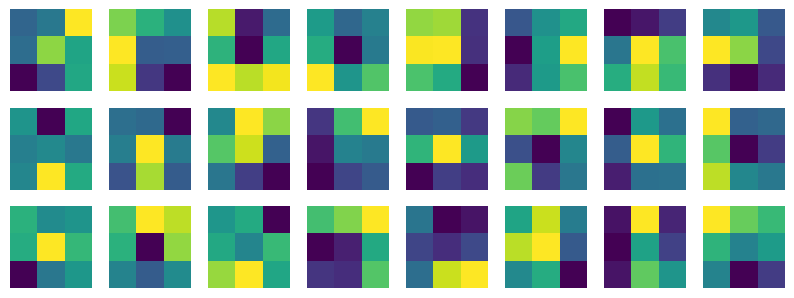

In [ ]:
# 獲取模型的第一个卷積層
conv1 = None
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        conv1 = module
        break
if conv1 is not None:
    weights = conv1.weight.data
    weight_array = weights.cpu().numpy()
    num_kernels = weight_array.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(num_kernels):
        plt.subplot(8, 8, i + 1)
        plt.imshow(weight_array[i, 0, :, :], cmap='viridis')
        plt.axis('off')
    plt.show()
else:
    print("layer not found")

Shape of the first layer feature map: torch.Size([1, 24, 112, 112])


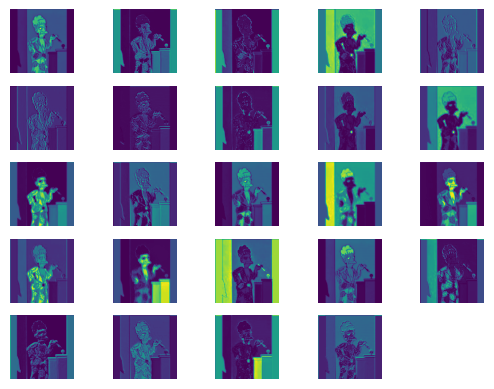

In [ ]:
# 載入一張圖片（替換為你的圖片路徑）
from PIL import Image
img_path = '/content/drive/MyDrive/machine_learning/HW2/img/train/agnes_skinner/ENQ_13.jpg'
img = Image.open(img_path)

# 適當的圖像預處理
preprocess = transforms.Compose([
    transforms.Resize(224),  # 調整圖像大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 將圖像轉換為Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = preprocess(img)
img = img.unsqueeze(0)  # 添加批次維度


# 獲得模型的第一層卷積層（Conv2d）
first_conv_layer = model.features[0]

# 創建一個模型，只包含第一層卷積層
first_layer_model = torch.nn.Sequential(first_conv_layer)

# 將圖片傳遞給第一層卷積層
with torch.no_grad():
    feature_map = first_layer_model(img)

# 打印第一層特徵圖的形狀
print("Shape of the first layer feature map:", feature_map.shape)

# 顯示第一層特徵圖的其中一個通道
for i in range(feature_map.size(1)):
    plt.subplot(feature_map.size(1)//5 + 1, 5, i + 1)  # 創建子圖
    plt.imshow(feature_map[0, i].cpu().numpy())
    # plt.title(f'Channel {i}')
    # plt.axis('off')
    plt.axis('off')  # 關閉座標軸

plt.show()

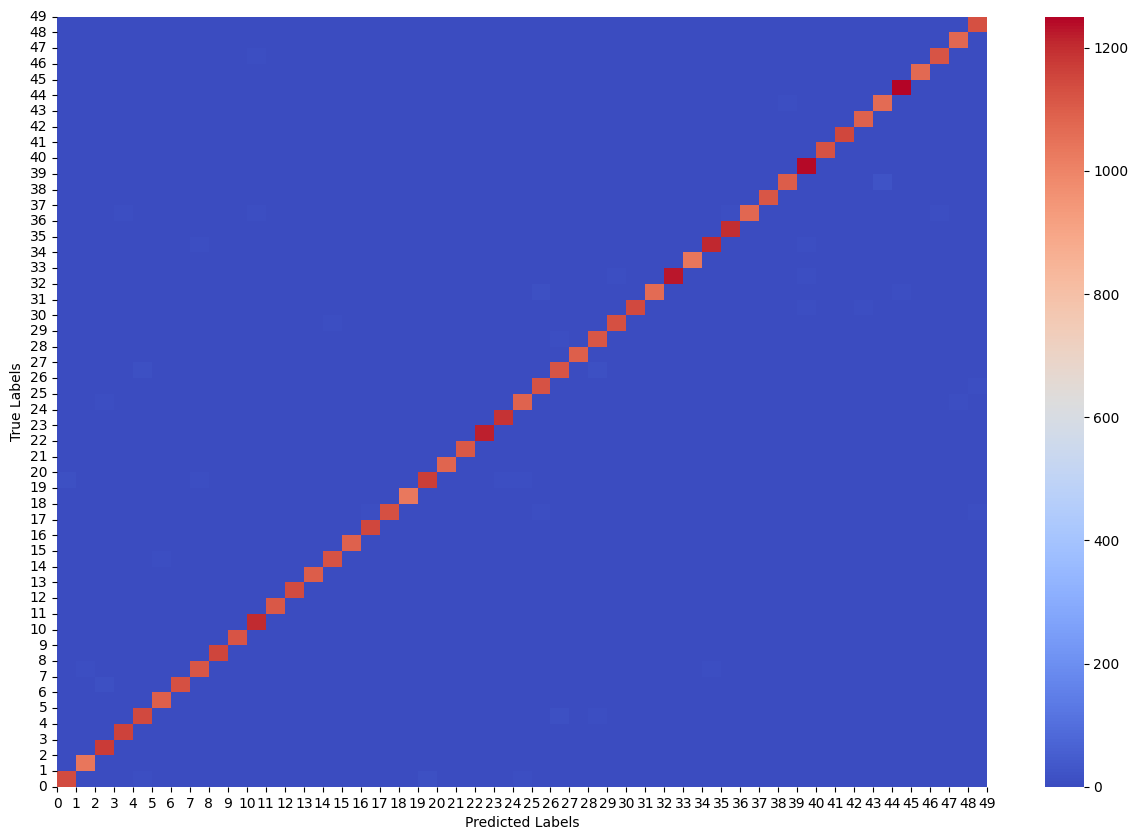

In [ ]:
predicted_labels = []
with torch.no_grad():
    for data in validationSetloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
true_labels = [label for _, label in validationSet]
# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels, labels=range(50))
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=False, cmap="coolwarm")
# 设置横轴和纵轴的刻度范围
plt.xticks(np.arange(50), np.arange(50))
plt.yticks(np.arange(50), np.arange(50))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

# Plot Train Loss Function

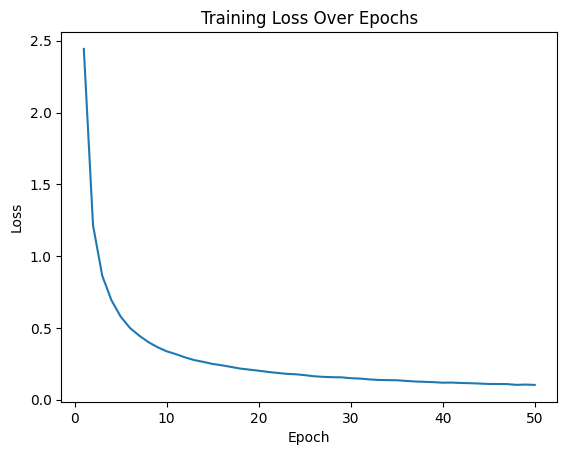

In [ ]:
df = pd.read_csv('/mount/ml/hw2/epoch_loss_data.csv')
epoch_list = df['Epoch']
loss_list = df['Loss']
plt.plot(epoch_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Predict the untrain img

In [ ]:
#predic
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in validationSetloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on the validation data: {100 * correct / total}%")
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in trainDataset.classes}
total_pred = {classname: 0 for classname in trainDataset.classes}
#no gradients needed
with torch.no_grad():
    for data in validationSetloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[trainDataset.classes[label]] += 1
            total_pred[trainDataset.classes[label]] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy on the validation data: 97.84402723334021%


RuntimeError: ignored

### 由於檔名讀取會亂掉(DataLoader那邊會打亂掉)，kaggle計分要用到，所以先每個檔案讀預測後存取成csv檔案，最後在讀近來，根據idx排序把檔案名稱照著小到大做排序

In [ ]:
#output
model.eval()
for key, image in testImages.items():
    image = image.to(device)
    image = image.unsqueeze(0)
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    predictedLabel = trainDataset.classes[predicted.item()]
    testImages[key] = predictedLabel
df = pd.DataFrame({'id': list(testImages.keys()), 'character': list(testImages.values())})
df.to_csv('/content/drive/MyDrive/machine_learning/HW2/output.csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/machine_learning/HW2/output.csv')
df = df.sort_values(by='id')
df.to_csv('/content/drive/MyDrive/machine_learning/HW2/predictions.csv', index=False)
print("All complete")